<a href="https://colab.research.google.com/github/ikyro/mnist/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download `training data` and `test data`

In [157]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
  root='data',
  train=True,
  download=True,
  transform=ToTensor()
)

test_data = datasets.MNIST(
  root='data',
  train=False,
  download=True,
  transform=ToTensor()
)

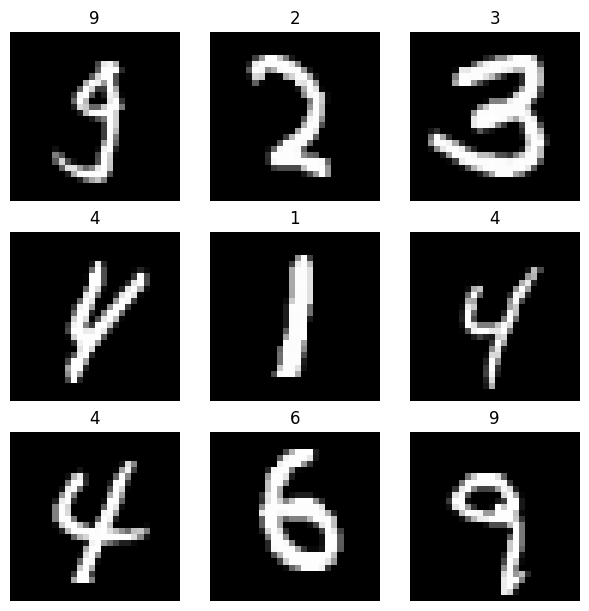

In [158]:
import matplotlib.pyplot as plt
import torch

figure = plt.figure(figsize=(6, 6), layout='constrained')
cols = 3
rows = 3

for i in range(cols * rows):
  rand_index = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[rand_index] # type: ignore
  figure.add_subplot(rows, cols, i + 1)
  plt.title(label)
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')

plt.show()

In [159]:
print(
  f'training data size: {training_data.data.size()}',
  f'test data size: {test_data.data.size()}',
  sep='\n'
)

#print(training_data.data.size()[1:])

training data size: torch.Size([60000, 28, 28])
test data size: torch.Size([10000, 28, 28])


In [160]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'

print(f'using: {device}')

using: cuda


In [161]:
from torch import nn

class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(in_features=28*28, out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512, out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512, out_features=10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)

    return logits

# Data Loaders

In [162]:
from torch.utils.data import DataLoader

training_loader = DataLoader(
  training_data,
  batch_size=100,
  shuffle=True,
  num_workers=2,
  pin_memory=True,
)

test_loader = DataLoader(
  test_data,
  batch_size=100,
  shuffle=True,
  num_workers=2,
  pin_memory=True,
)

# Model Instance

In [163]:
model = NeuralNetwork().to(device)

# Training Model

In [175]:
from torch import nn, optim
import numpy as np

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
epochs = 5

def train_model():
  for i, (inputs, labels) in enumerate(training_loader, start=1):
    inputs = inputs.to(device)
    labels = labels.clone().detach().to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)

    loss.backward()
    optimizer.step()

    if i % 10 == 0:
      current = i * len(inputs)

      print(
        f'loss: {loss.item():.4f}',
        f'[{current}/{len(training_data)}]'
      )

for epoch in range(1, epochs + 1):
  print(f'training epoch: [{epoch}/{epochs}]')

  model.train()
  train_model()

training epoch: [1/5]
loss: 0.0008 [1000/60000]
loss: 0.0001 [2000/60000]
loss: 0.0001 [3000/60000]
loss: 0.0000 [4000/60000]
loss: 0.0005 [5000/60000]
loss: 0.0103 [6000/60000]
loss: 0.0002 [7000/60000]
loss: 0.0000 [8000/60000]
loss: 0.0000 [9000/60000]
loss: 0.0001 [10000/60000]
loss: 0.0003 [11000/60000]
loss: 0.0002 [12000/60000]
loss: 0.0048 [13000/60000]
loss: 0.0002 [14000/60000]
loss: 0.0005 [15000/60000]
loss: 0.0054 [16000/60000]
loss: 0.0000 [17000/60000]
loss: 0.0076 [18000/60000]
loss: 0.0000 [19000/60000]
loss: 0.0157 [20000/60000]
loss: 0.0026 [21000/60000]
loss: 0.0000 [22000/60000]
loss: 0.0002 [23000/60000]
loss: 0.0000 [24000/60000]
loss: 0.0054 [25000/60000]
loss: 0.0001 [26000/60000]
loss: 0.0171 [27000/60000]
loss: 0.0001 [28000/60000]
loss: 0.0014 [29000/60000]
loss: 0.0011 [30000/60000]
loss: 0.0005 [31000/60000]
loss: 0.0001 [32000/60000]
loss: 0.0011 [33000/60000]
loss: 0.0000 [34000/60000]
loss: 0.0162 [35000/60000]
loss: 0.0023 [36000/60000]
loss: 0.0049 [3

# Evaluation Model

In [176]:
def eval_model():
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader, start=1):
      inputs = inputs.to(device)
      labels = labels.clone().detach().to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, labels)

      if i % 5 == 0:
        current = i * len(inputs)

        print(f"loss: {loss.item():.4f} acc: {(outputs.argmax(1) == labels).float().mean().item():.4f} [{current}/{len(test_data)}]")

for epoch in range(1, epochs + 1):
  print(f'epoch: [{epoch}/{epochs}]')

  model.eval()
  eval_model()

epoch: [1/5]
loss: 0.0521 acc: 0.9800 [500/10000]
loss: 0.0493 acc: 0.9900 [1000/10000]
loss: 0.2351 acc: 0.9700 [1500/10000]
loss: 0.0609 acc: 0.9800 [2000/10000]
loss: 0.0002 acc: 1.0000 [2500/10000]
loss: 0.0002 acc: 1.0000 [3000/10000]
loss: 0.0001 acc: 1.0000 [3500/10000]
loss: 0.1836 acc: 0.9800 [4000/10000]
loss: 0.0216 acc: 0.9900 [4500/10000]
loss: 0.2257 acc: 0.9700 [5000/10000]
loss: 0.0072 acc: 1.0000 [5500/10000]
loss: 0.3239 acc: 0.9800 [6000/10000]
loss: 0.2553 acc: 0.9800 [6500/10000]
loss: 0.4591 acc: 0.9700 [7000/10000]
loss: 0.0855 acc: 0.9900 [7500/10000]
loss: 0.0748 acc: 0.9900 [8000/10000]
loss: 0.0541 acc: 0.9900 [8500/10000]
loss: 0.0166 acc: 0.9900 [9000/10000]
loss: 0.0605 acc: 0.9800 [9500/10000]
loss: 0.2136 acc: 0.9800 [10000/10000]
epoch: [2/5]
loss: 0.2723 acc: 0.9700 [500/10000]
loss: 0.0849 acc: 0.9900 [1000/10000]
loss: 0.0471 acc: 0.9900 [1500/10000]
loss: 0.3087 acc: 0.9400 [2000/10000]
loss: 0.0082 acc: 1.0000 [2500/10000]
loss: 0.0001 acc: 1.0000 

# Prediction Mode

In [147]:
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


url: https://p.kindpng.com/picc/s/770-7707591_silhouette-neck-hand-hand-written-number-9-hd.png
torch.Size([1, 28, 28])
tensor([ -9.0684, -16.7683, -20.3056,  -9.8334, -33.2004,   9.8081, -13.6425,
         -0.5963, -31.2247, -16.1627], device='cuda:0')
model preddiction: 5


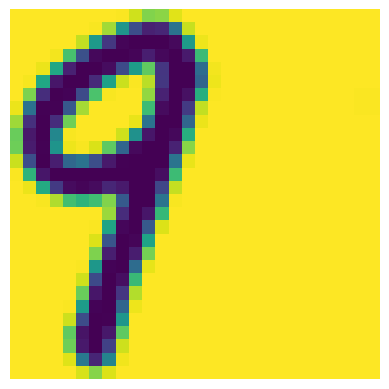

In [180]:
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize((28, 28)),
  transforms.Grayscale(),
  transforms.PILToTensor(),
  transforms.ConvertImageDtype(torch.float32)
])

def show_image(url: str):
  res = requests.get(url)
  img = Image.open(BytesIO(res.content))

  tensor = transform(img)

  plt.axis('off')
  plt.imshow(tensor.squeeze()) # type: ignore

  return tensor

img_tensor = show_image(input('url: '))
print(img_tensor.shape) # type: ignore

with torch.no_grad():
  model.eval()
  output = model(img_tensor.to(device)) # type: ignore
  predicted = output.argmax().item()

  print(output[0])
  print(f'model preddiction: {predicted}')